In [1]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import readline
import rpy2.robjects
import time
#from ZIFA import ZIFA
#from ZIFA import block_ZIFA
import pylab

In [2]:
%load_ext rpy2.ipython

In [5]:
%%R
library(scde, quietly = TRUE)
library(DESeq2, quietly = TRUE)
library(ggplot2, quietly = TRUE)
library(made4, quietly = TRUE)
library(irlba, quietly = TRUE)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)

In [5]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/GeneNames.txt")

In [6]:
%%R
cdStromal <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/AllHtseqCountsStromal.tsv", sep=",",header=TRUE, row.names=1)
colnames(cdStromal) <- paste0("Stromal_C",c(1:96))
rownames(cdStromal) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdStromal) <- sub("_.*", "_Stromal", colnames(cdStromal))
head(cdStromal)

         Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
TSPAN6            0          0          0          0          0          0
TNMD              0          0          0          0          0          0
DPM1              0          0          0          0          0          0
SCYL3             0          0          0          0          0          0
C1orf112          0          0          0          0          0          0
FGR               0          0          0          0          0          0
         Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
TSPAN6            0          0          0           0           0           0
TNMD              0          0          0           0           0           0
DPM1              0          0          0           0           0           0
SCYL3             0          0          0           0           0           0
C1orf112          0          0          0           0           0           0
FGR    

In [7]:
%%R
cdTumour <- read.table("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/AllHtseqCountsTumour.tsv", sep=",",header=TRUE, row.names=1)
colnames(cdTumour) <- paste0("Tumor_C",c(1:96))
rownames(cdTumour) <- make.names(GeneName$V1, unique=TRUE)
#colnames(cdTumour) <- sub("_.*", "_Tumour", colnames(cdTumour))
head(cdTumour)

         Tumor_C1 Tumor_C2 Tumor_C3 Tumor_C4 Tumor_C5 Tumor_C6 Tumor_C7
TSPAN6          6        0        8        5      150        0       56
TNMD            0        0        0        0        0        0        0
DPM1          109      189       37      177      101      237       36
SCYL3           0        7        0        0        0       10        0
C1orf112        0        8        0        0        0        2        7
FGR             0        0        0        0        0        0        0
         Tumor_C8 Tumor_C9 Tumor_C10 Tumor_C11 Tumor_C12 Tumor_C13 Tumor_C14
TSPAN6          1       28        95         4         0       469         0
TNMD            0        0         0         0         0         0         0
DPM1           35       83        84       125         3         0        59
SCYL3           5        1         3         0         0         0        15
C1orf112        0        0         2         2         0         0        12
FGR             0        0        

In [8]:
%%R
cdAll <- cbind(cdStromal, cdTumour)
head(cdAll)

         Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
TSPAN6            0          0          0          0          0          0
TNMD              0          0          0          0          0          0
DPM1              0          0          0          0          0          0
SCYL3             0          0          0          0          0          0
C1orf112          0          0          0          0          0          0
FGR               0          0          0          0          0          0
         Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
TSPAN6            0          0          0           0           0           0
TNMD              0          0          0           0           0           0
DPM1              0          0          0           0           0           0
SCYL3             0          0          0           0           0           0
C1orf112          0          0          0           0           0           0
FGR    

In [10]:
%%R
# clean up the dataset
cdFiltered <- clean.counts(cdAll, min.lib.size=500, min.reads = 10, min.detected = 5)
print(dim(cdFiltered))

[1] 19107   185


In [11]:
%%R
StromalNo <- (sum(sapply(regmatches(colnames(cdFiltered), gregexpr("Stromal", colnames(cdFiltered))), length)))
TumorNo <- (sum(sapply(regmatches(colnames(cdFiltered), gregexpr("Tumor", colnames(cdFiltered))), length)))
print(paste0("Stromal Cells: ",StromalNo))
print(paste0("Tumor Cells: ",TumorNo))

[1] "Stromal Cells: 89"
[1] "Tumor Cells: 96"


In [12]:
%%R
FilteredDataInfo <- data.frame(Cell=colnames(cdFiltered), Status=c(rep('Stormal',StromalNo), rep('Tumor',TumorNo)))
rownames(FilteredDataInfo ) <- colnames(cdFiltered)

In [13]:
%%R
pd <- new("AnnotatedDataFrame", data = FilteredDataInfo)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFiltered, phenoData = pd)

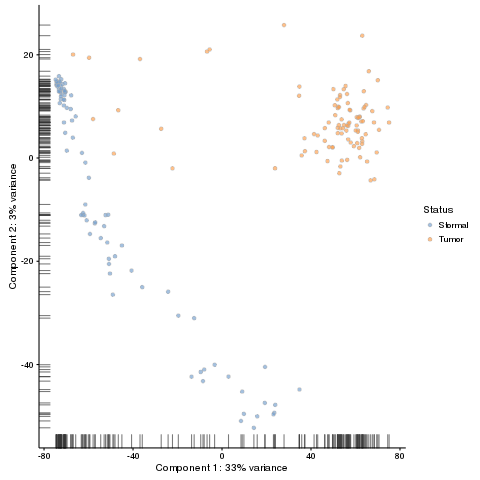

In [14]:
%%R
plotPCA(cdScesetFiltered, ncomponents = 2, colour_by = "Status", ntop=10000)

In [15]:
%%R
colnames(exprs(cdScesetFiltered))

  [1] "Stromal_C1"  "Stromal_C2"  "Stromal_C3"  "Stromal_C4"  "Stromal_C5" 
  [6] "Stromal_C6"  "Stromal_C7"  "Stromal_C8"  "Stromal_C9"  "Stromal_C10"
 [11] "Stromal_C11" "Stromal_C12" "Stromal_C13" "Stromal_C14" "Stromal_C15"
 [16] "Stromal_C16" "Stromal_C17" "Stromal_C18" "Stromal_C19" "Stromal_C20"
 [21] "Stromal_C21" "Stromal_C22" "Stromal_C23" "Stromal_C24" "Stromal_C25"
 [26] "Stromal_C26" "Stromal_C27" "Stromal_C28" "Stromal_C29" "Stromal_C30"
 [31] "Stromal_C31" "Stromal_C32" "Stromal_C33" "Stromal_C34" "Stromal_C35"
 [36] "Stromal_C36" "Stromal_C37" "Stromal_C38" "Stromal_C39" "Stromal_C40"
 [41] "Stromal_C41" "Stromal_C42" "Stromal_C43" "Stromal_C44" "Stromal_C45"
 [46] "Stromal_C46" "Stromal_C47" "Stromal_C48" "Stromal_C49" "Stromal_C50"
 [51] "Stromal_C51" "Stromal_C52" "Stromal_C53" "Stromal_C54" "Stromal_C55"
 [56] "Stromal_C56" "Stromal_C58" "Stromal_C59" "Stromal_C60" "Stromal_C61"
 [61] "Stromal_C62" "Stromal_C63" "Stromal_C64" "Stromal_C65" "Stromal_C66"
 [66] "Strom

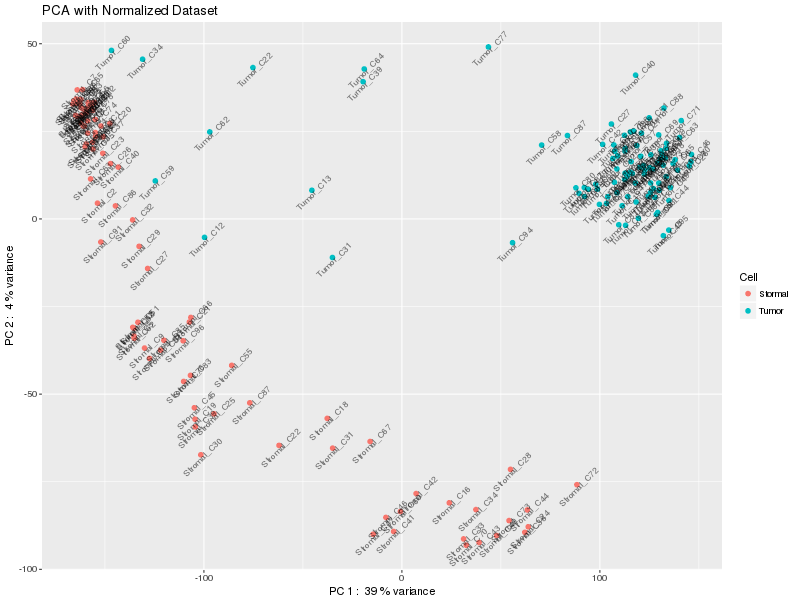

In [17]:
%%R -w 800 -h 600
FinalPCAData <- t(exprs(cdScesetFiltered)[1:10000,])
sampleCondition <- FilteredDataInfo$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Normalized Dataset")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFiltered))),alpha=0.5,size=3, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [4]:
%%R
load("Louisa_Workspace_updated.RData")

In [10]:
%%R
#stromalBlueDF <- df[df$PCX> -50 & df$PCY< -70,]
#print(dim(stromalBlueDF))
#stromalBlueCells <- rownames(stromalBlueDF)
stromalBlueCells <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/stromalBlueCells.csv', row.names=1, header=F)
#print(head(stromalBlueCells$V2))
stromalCD <- cdFiltered[,1:89]
stromalBlueCellsFiltCount <- stromalCD[,stromalBlueCells$V2]
stromalRegularCellsFiltCount <- stromalCD[,!(colnames(stromalCD) %in% stromalBlueCells$V2)]
print(dim(stromalBlueCellsFiltCount))
print(dim(stromalRegularCellsFiltCount))
#write.csv(stromalBlueCells,'stromalBlueCells.csv')

[1] 19107    20
[1] 19107    69


In [11]:
%%R
save.image("Louisa_Workspace_updated.RData")

In [12]:
%%R
colnames(stromalBlueCellsFiltCount) <- paste0(colnames(stromalBlueCellsFiltCount),'_Blue')
colnames(stromalRegularCellsFiltCount) <- paste0(colnames(stromalRegularCellsFiltCount),'_Regular')

In [13]:
%%R
cd <- cbind(stromalBlueCellsFiltCount, stromalRegularCellsFiltCount)
sg <- factor(gsub(".*_(Blue|Regular)", "\\1", colnames(cd)),levels=c("Blue", "Regular"))
names(sg) <- colnames(stromalCD)
table(sg)

sg
   Blue Regular 
     20      69 


In [25]:
%%R
o.ifm <- scde.error.models(counts = cd, groups = sg, n.cores = 2, 
                           threshold.segmentation = TRUE, 
                           save.crossfit.plots = FALSE, 
                           save.model.plots = FALSE, verbose = 1)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: cross-fitting 2692 pairs:

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: adjusting library size based on 2000 entries

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: fitting Blue models:

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1 : Stromal_C16_Blue
Classification: weighted 
   1 Log-likelihood :  -31343.7566 
   2 Log-likelihood :  -31320.9791 
   3 Log-likelihood :  -31311.3898 
   4 Log-likelihood :  -31307.7384 
   5 Log-likelihood :  -31307.1615 
   6 Log-likelihood :  -31307.5214 
   7 Log-likelihood :  -31308.2308 
   8 Log-likelihood :  -31309.0031 
   9 Log-likelihood :  -31309.7379 
  10 Log-likelihood :  -31

cross-fitting cells.
number of pairs:  136 
number of pairs:  2556 
total number of pairs:  2692 
building individual error models.


In [26]:
%%R
# filter out cells that don't show positive correlation with
# the expected expression magnitudes (very poor fits)
valid.cells <- o.ifm$corr.a > 0
table(valid.cells)

valid.cells
TRUE 
  89 


In [27]:
%%R
o.prior <- scde.expression.prior(models = o.ifm, counts = cd, length.out = 400, show.plot = FALSE)

In [28]:
%%R
# define two groups of cells
groups <- factor(gsub(".*_(Blue|Regular)", "\\1", colnames(cd)),levels=c("Blue", "Regular"))
names(groups) <- row.names(o.ifm)
# run differential expression tests on all genes.
ediff <- scde.expression.difference(o.ifm, cd, o.prior, groups  =  groups, n.randomizations  =  100, n.cores  =  1, verbose  =  1)

comparing groups:

   Blue Regular 
     17      72 
calculating difference posterior
summarizing differences


In [29]:
%%R
# top upregulated genes (tail would show top downregulated ones)
head(ediff[order(ediff$Z, decreasing  =  TRUE), ])

                 lb      mle        ub       ce        Z       cZ
WNT5A      1.466975 2.168571  2.997731 1.466975 7.120376 5.607176
GPR22      7.749454 8.993193  9.662899 7.749454 6.941170 5.503889
PPP6R3     8.482941 9.407773 10.045588 8.482941 6.841101 5.451125
SRSF6      2.455588 4.113907  5.740336 2.455588 6.750359 5.409875
AP000769.1 2.391807 3.220966  4.113907 2.391807 6.734018 5.409875
SLC35F5    7.015966 8.451050  9.120756 7.015966 6.589212 5.265617


In [30]:
%%R
# write out a table with all the results, showing most significantly different genes (in both directions) on top
write.table(ediff[order(abs(ediff$Z), decreasing = TRUE), ], file = "SCDE_results.csv", row.names = TRUE, col.names = TRUE, sep = "\t", quote = FALSE)

In [ ]:
%%R
scde.test.gene.expression.difference("S100a6", models = o.ifm, counts = cd, prior = o.prior)

In [31]:
%%R
expressionSCDE <- read.csv("SCDE_results.csv", sep='\t')
head(expressionSCDE)

                 lb      mle        ub       ce        Z       cZ
WNT5A      1.466975 2.168571  2.997731 1.466975 7.120376 5.607176
GPR22      7.749454 8.993193  9.662899 7.749454 6.941170 5.503889
PPP6R3     8.482941 9.407773 10.045588 8.482941 6.841101 5.451125
SRSF6      2.455588 4.113907  5.740336 2.455588 6.750359 5.409875
AP000769.1 2.391807 3.220966  4.113907 2.391807 6.734018 5.409875
SLC35F5    7.015966 8.451050  9.120756 7.015966 6.589212 5.265617


In [32]:
%%R
expressionModSCDE <- data.frame(Log2Fold = expressionSCDE$mle, pvalue=2*pnorm(-abs(expressionSCDE$Z)),qvalue=2*pnorm(-abs(expressionSCDE$cZ)))
rownames(expressionModSCDE) <- rownames(expressionSCDE)
print(head(expressionModSCDE))
write.csv(expressionModSCDE, 'SCDE_results_Regular_vs_Blue_Stromal.csv', row.names=TRUE)

           Log2Fold       pvalue       qvalue
WNT5A      2.168571 1.076328e-12 2.056540e-08
GPR22      8.993193 3.888665e-12 3.715036e-08
PPP6R3     9.407773 7.858697e-12 5.005204e-08
SRSF6      4.113907 1.474795e-11 6.306860e-08
AP000769.1 3.220966 1.650405e-11 6.306860e-08
SLC35F5    8.451050 4.421663e-11 1.397193e-07


__SCDE__ for Tumor vs Blue Stromal Cells

In [33]:
%%R
TumorCount <- cdFiltered[,90:185]
colnames(TumorCount) <- paste0(colnames(TumorCount),'_Tumor')
cd <- cbind(stromalBlueCellsFiltCount, TumorCount)
sg <- factor(gsub(".*_(Blue|Tumor)", "\\1", colnames(cd)),levels=c("Blue", "Tumor"))
names(sg) <- colnames(cd)
table(sg)

sg
 Blue Tumor 
   17    96 


In [34]:
%%R
o.ifm <- scde.error.models(counts = cd, groups = sg, n.cores = 2, 
                           threshold.segmentation = TRUE, 
                           save.crossfit.plots = FALSE, 
                           save.model.plots = FALSE, verbose = 1)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: cross-fitting 4696 pairs:

  warnings.warn(x, RRuntimeWarning)
/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: 'bplapply' receive data failed:
  error reading from connection

  warnings.warn(x, RRuntimeWarning)


cross-fitting cells.
number of pairs:  136 
number of pairs:  4560 
total number of pairs:  4696 
building individual error models.
Error: 'bplapply' receive data failed:
  error reading from connection


In [35]:
%%R
# filter out cells that don't show positive correlation with
# the expected expression magnitudes (very poor fits)
valid.cells <- o.ifm$corr.a > 0
table(valid.cells)

valid.cells
TRUE 
  89 


In [36]:
%%R
o.prior <- scde.expression.prior(models = o.ifm, counts = cd, length.out = 400, show.plot = FALSE)


Error in scde.expression.magnitude(models, counts) : 
  ERROR: provided count data does not cover all of the cells specified in the model matrix


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in scde.expression.magnitude(models, counts) : 
  ERROR: provided count data does not cover all of the cells specified in the model matrix

  warnings.warn(x, RRuntimeWarning)


In [42]:
%%R
print(stromalBlueCells)

character(0)


In [17]:
%%R
# Taking CPM normalized value for clustering from cdScesetFiltered
cdFilteredForCluster <- exprs(cdScesetFiltered)
cdFilteredForCluster <- cdFilteredForCluster[order(rowVars(cdFilteredForCluster), decreasing = TRUE)[1:10000],]
colAnnot = data.frame(type = c(rep('Stormal',StromalNo), rep('Tumor',TumorNo)))
ha = HeatmapAnnotation(df = colAnnot)

###############################
# I turned this Heatmap option off as it took lots of memory to run from jupyter notebook
#png("CPM_Normalized_Low_Threshold_HirerClust.png", height=1000, width=1700)
#Heatmap(cdFilteredForCluster, show_row_dend=FALSE, show_row_names = FALSE, column_names_gp = gpar(fontsize = 9), top_annotation = ha)
#dev.off()

In [19]:
%%R
head(cdFilteredForCluster)

         Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5 Stromal_C6
ARRDC3     1.387364   1.387364   1.387364   1.387364   1.387364   4.834305
BICC1      1.387364   1.387364   1.387364   1.387364   1.387364   1.387364
TBL1XR1    5.955712   3.474711   5.946829   9.654487   1.387364   1.387364
SERPINE1  12.494152   4.813491  14.036819   8.589240  13.510702  13.265786
ANP32E     5.015274  13.058201   1.387364   1.387364   1.387364   4.834305
HSP90AA1   5.015274  11.902420   1.387364   1.387364   1.387364   1.387364
         Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10 Stromal_C11 Stromal_C12
ARRDC3     1.387364   1.387364   1.387364    1.387364    1.387364    1.387364
BICC1      1.387364   1.387364   1.387364    1.387364    1.387364    1.387364
TBL1XR1    4.681928   1.387364   1.387364    4.757377    6.116206    1.387364
SERPINE1  11.060002   7.714624  12.100674   11.986589    9.006702   13.662019
ANP32E     3.821940   7.714624  11.754517    1.387364    1.387364    1.387364
HSP90AA

In [20]:
%%R
StromalReassigned = sort(c(46,47,41,44,73,28,42,31,67,60,16,43,33,34,70,49,38,24,72),decreasing=FALSE)
TumorReassigned = sort(c(13,31,22,62,12,34,59,60),decreasing=FALSE)
StromalReasName = paste0("Stromal_C", StromalReassigned)
TumorReasName = paste0("Tumor_C", TumorReassigned)

In [21]:
%%R
cdFilteredReas <- cdFiltered
rownames(cdFilteredReas) <- make.names(gsub("\\..*","",rownames(cdFilteredReas)), unique=TRUE)
colnames(cdFilteredReas)[colnames(cdFilteredReas) %in% StromalReasName] <- paste0("Re_",StromalReasName)
colnames(cdFilteredReas)[colnames(cdFilteredReas) %in% TumorReasName] <- paste0("Re_",TumorReasName)

In [22]:
%%R
head(rownames(cdFilteredReas))

[1] "TSPAN6"   "DPM1"     "SCYL3"    "C1orf112" "CFH"      "FUCA2"   


In [23]:
%%R
write.csv(cdFilteredReas, 'cdFilteredReasGeneAnnot.csv')

NULL


In [25]:
%%R
FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredReas)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)
#gsub("\\_C*","",colnames(cdFilteredForClusterReas))

In [26]:
%%R
FilteredDataInfoReas$Status

  [1] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
  [7] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
 [13] Stromal    Stromal    Stromal    Re_Stromal Stromal    Stromal   
 [19] Stromal    Stromal    Stromal    Stromal    Stromal    Re_Stromal
 [25] Stromal    Stromal    Stromal    Re_Stromal Stromal    Stromal   
 [31] Re_Stromal Stromal    Re_Stromal Re_Stromal Stromal    Stromal   
 [37] Stromal    Re_Stromal Stromal    Stromal    Re_Stromal Re_Stromal
 [43] Re_Stromal Re_Stromal Stromal    Re_Stromal Re_Stromal Stromal   
 [49] Re_Stromal Stromal    Stromal    Stromal    Stromal    Stromal   
 [55] Stromal    Stromal    Stromal    Stromal    Re_Stromal Stromal   
 [61] Stromal    Stromal    Stromal    Stromal    Stromal    Re_Stromal
 [67] Stromal    Stromal    Re_Stromal Stromal    Re_Stromal Re_Stromal
 [73] Stromal    Stromal    Stromal    Stromal    Stromal    Stromal   
 [79] Stromal    Stromal    Stromal    Stromal    Stromal    Str

In [27]:
%%R
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFilteredReas <- newSCESet(countData = cdFilteredReas, phenoData = pd)

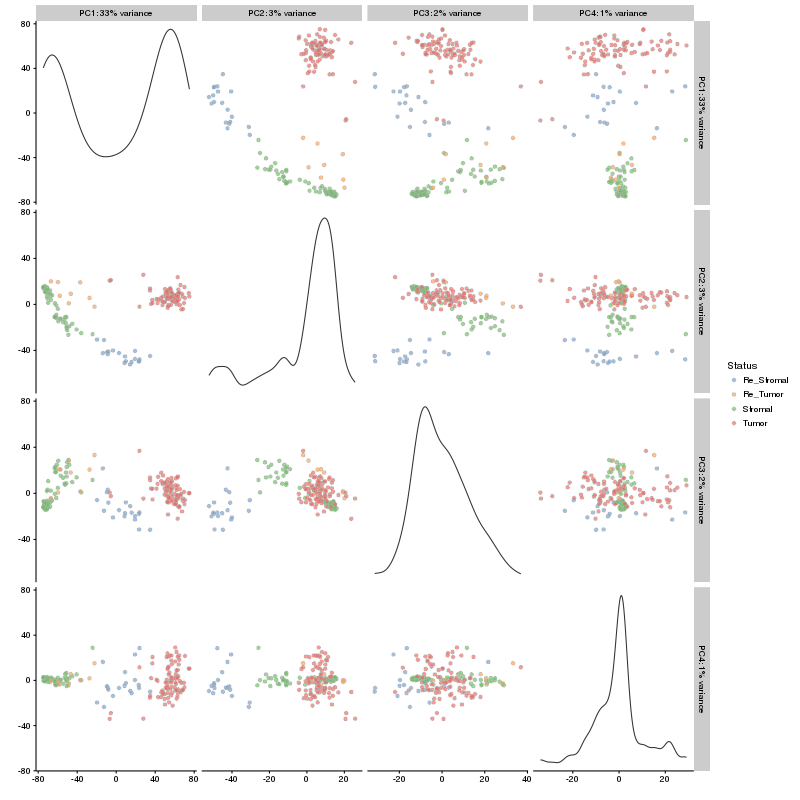

In [28]:
%%R -w 800 -h 800
plotPCA(cdScesetFilteredReas, ncomponents = 4, colour_by = "Status", ntop=10000)

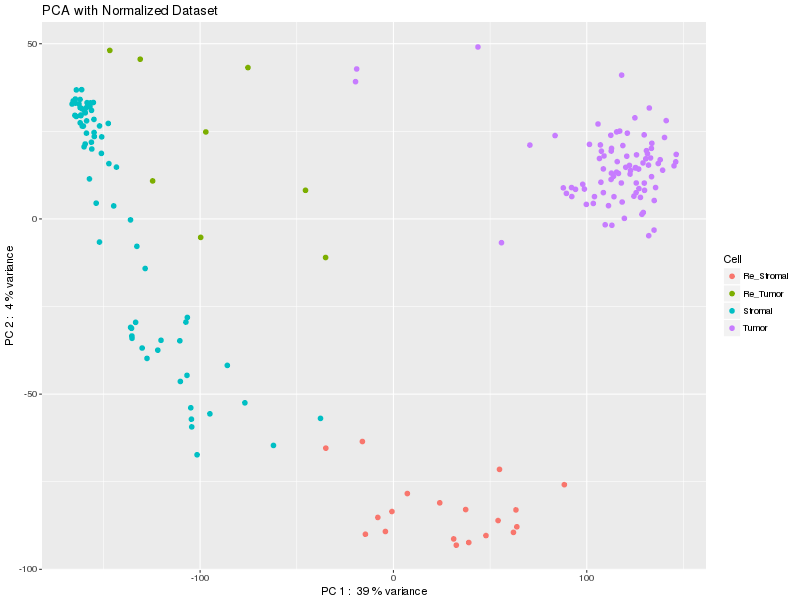

In [29]:
%%R -w 800 -h 600
FinalPCAData <- t(exprs(cdScesetFilteredReas)[1:10000,])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Normalized Dataset")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [80]:
%%R
write.csv(df, "Component_value_For_Reassigned.csv")

NULL


[1] 17  3
[1] 19107    17


In [55]:
%%R
cdScesetFilteredReas <- calculateQCMetrics(cdScesetFilteredReas)

In [56]:
%%R
save.image("Louisa_Workspace.RData")

In [57]:
%%R
names(pData(cdScesetFilteredReas))

 [1] "Cell"                                 
 [2] "Status"                               
 [3] "total_counts"                         
 [4] "log10_total_counts"                   
 [5] "filter_on_total_counts"               
 [6] "total_features"                       
 [7] "log10_total_features"                 
 [8] "filter_on_total_features"             
 [9] "pct_dropout"                          
[10] "exprs_feature_controls"               
[11] "pct_exprs_feature_controls"           
[12] "filter_on_pct_exprs_feature_controls" 
[13] "pct_exprs_top_50_features"            
[14] "pct_exprs_top_100_features"           
[15] "pct_exprs_top_200_features"           
[16] "counts_feature_controls"              
[17] "pct_counts_feature_controls"          
[18] "filter_on_pct_counts_feature_controls"
[19] "pct_counts_top_50_features"           
[20] "pct_counts_top_100_features"          
[21] "pct_counts_top_200_features"          
[22] "n_detected_feature_controls"          
[23] "expr

In [58]:
%%R
plot.scores.self <- function(df, Cell, Status,legend.title, plot.title){  
  
  df$Status <- as.factor(Status) 
  p<-ggplot(data=df, aes(x=x,y=y,color=Status))
  p+geom_point(size=2)+
    xlab("G1 score")+
    ylab("G2M score")+
    ylim(0,1)+
    xlim(0,1)+
    ggtitle(plot.title)+
    theme(axis.title.x = element_text(size=10, vjust=-2),
          axis.text.x  = element_text( size=10),
          axis.title.y = element_text( size=10,vjust=2),
          axis.text.y  = element_text( size=10)) +
    theme(plot.margin=unit(c(1,1,1.5,1.2),"cm"))+
    theme(legend.text=element_text(size=10),#size of legend
          legend.title=element_text(size=10), 
          plot.title = element_text(size=20, face="bold"))+
    scale_color_discrete(name=legend.title)+
    geom_segment(aes(x = 1/2, y = 0, xend=1/2, yend=1/2),colour="black") + 
    geom_segment(aes(x = 0, y = 1/2, xend=1/2, yend=1/2),colour="black") +
    geom_segment(aes(x = 1/2, y = 1/2, xend=1, yend=1),colour="black") +
    annotate("text", x=0.05, y=0.05, label="S", size=8)+
    annotate("text", x=0.95, y=0.25, label="G1", size=8)+
    annotate("text", x=0.25, y=0.95, label="G2M", size=8)+
    geom_text(data=df,aes(label=Cell),alpha=0.5,size=5, vjust=1,hjust=0.5,angle=45, color="black")  
  
}

In [5]:
%%R
load("Louisa_Workspace.RData")

In [46]:
%%R
cdFilteredReasGeneID <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReas.csv', row.names=1, header=TRUE)

FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReasGeneID), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredReasGeneID)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReasGeneID)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFilteredReasGeneID <- newSCESet(countData = cdFilteredReasGeneID, phenoData = pd)

In [16]:
%%R
write.csv(exprs(cdScesetFilteredReasGeneID), 'GeneID_log(cpm)_normalized.csv')

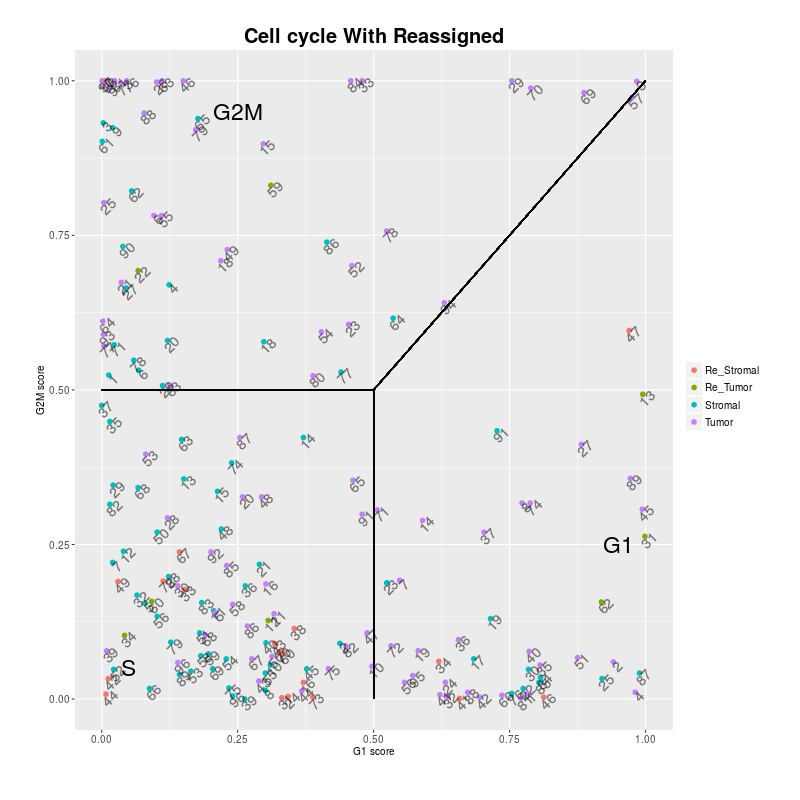

In [262]:
%%R -w 800 -h 800
############
### Commenting the other line as cyclone run outs of memory if we run it here
#cdFilteredReasGeneID <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReas.csv', row.names=1, header=TRUE)
#FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredForClusterReas)))
#rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)
#pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
#rownames(pd) <- pd$Cell
#cdScesetFilteredReasGeneID <- newSCESet(countData = cdFilteredReasGeneID, phenoData = pd)
#hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))
#assigned <- cyclone(cdScesetFilteredReasGeneID, pairs=hg.pairs)
#head(assigned$scores)
#phase <- rep("S", ncol(cdScesetFilteredReas))
#phase[assigned$scores$G1 > 0.5] <- "G1"
#phase[assigned$scores$G2M > 0.5] <- "G2M"
#phase[assigned$scores$G1 > 0.5 & assigned$scores$G2M > 0.5] <- "unknown"
#table(phase)
#phase
#assigned$scores
#labels.qseq <- rep("Cell", length(colnames(cdFilteredReas)) )
#df.scores<-data.frame(x=assigned$scores[,1], 
#                      y=assigned$scores[,3], 
#                      z=labels.qseq )

plot.scores.self(df.scores,gsub('([A-z]+)', '\\2',(cdScesetFilteredReas$Cell)), cdScesetFilteredReas$Status, legend.title="",plot.title="Cell cycle With Reassigned")


In [255]:
%%R
rownames(assigned$scores) <- cdScesetFilteredReas$Cell
write.csv(assigned$scores, "CellCycleAssignment.csv")

In [259]:
%%R
CycleAssigned <- data.frame(Cells = cdScesetFilteredReas$Cell, Phases = phase )
write.csv(CycleAssigned, "CycleAssigned.csv")

In [59]:
%%R
write.csv(exprs(cdScesetFilteredReas), "log2(cpm)_normalized_Filtered_Gene_Annot.csv")

In [66]:
%%R
write.csv(exprs(cdScesetFilteredReas)[grep('TP53',rownames(cdScesetFilteredReas), ignore.case=FALSE),], 'AllTP53.csv')

In [81]:
%%R
write.csv(get_exprs(cdScesetFilteredReas, "cpm"), "cpm_normalized_Filtered_Gene_Annot.csv")

## Removing cell-cycle effect

In [17]:
%%R
head(exprs(cdScesetFilteredReasGeneID))

                Stromal_C1 Stromal_C2 Stromal_C3 Stromal_C4 Stromal_C5
ENSG00000000003          0          0          0          0          0
ENSG00000000419          0          0          0          0          0
ENSG00000000457          0          0          0          0          0
ENSG00000000460          0          0          0          0          0
ENSG00000000971          0          0          0          0          0
ENSG00000001036          0          0          0          0          0
                Stromal_C6 Stromal_C7 Stromal_C8 Stromal_C9 Stromal_C10
ENSG00000000003          0          0          0   0.000000           0
ENSG00000000419          0          0          0   0.000000           0
ENSG00000000457          0          0          0   0.000000           0
ENSG00000000460          0          0          0   0.000000           0
ENSG00000000971          0          0          0   0.000000           0
ENSG00000001036          0          0          0   4.428639           0

In [6]:
%%R
hg.pairs <- readRDS(system.file("exdata", "human_cycle_markers.rds", package="scran"))

In [250]:
%%R
x <- t(scale(t(exprs(cdScesetFilteredReasGeneID)), scale=FALSE, center=TRUE))
allGenes <- data.frame(geneName=rownames(x), Status=FALSE)
allGenes[as.character(allGenes$geneName) %in% hg.pairs$G1$first,2] = TRUE
allGenes[as.character(allGenes$geneName) %in% hg.pairs$G2M$first,2] = TRUE
allGenes[as.character(allGenes$geneName) %in% hg.pairs$S$first,2] = TRUE
if.cc <- allGenes[,2]
dat <-list(x =x ,if.cc = if.cc)

In [251]:
%%R
CellCycleRemoved <- ccRemover.main(dat,cutoff=3, max.it=4, nboot=200, ntop=10)


Iteration  1 ...
Bootstrapping 1 ...
Bootstrapping 2 ...
Bootstrapping 3 ...
Bootstrapping 4 ...
Bootstrapping 5 ...
Bootstrapping 6 ...
Bootstrapping 7 ...
Bootstrapping 8 ...
Bootstrapping 9 ...
Bootstrapping 10 ...
Bootstrapping 11 ...
Bootstrapping 12 ...
Bootstrapping 13 ...
Bootstrapping 14 ...
Bootstrapping 15 ...
Bootstrapping 16 ...
Bootstrapping 17 ...
Bootstrapping 18 ...
Bootstrapping 19 ...
Bootstrapping 20 ...
Bootstrapping 21 ...
Bootstrapping 22 ...
Bootstrapping 23 ...
Bootstrapping 24 ...
Bootstrapping 25 ...
Bootstrapping 26 ...
Bootstrapping 27 ...
Bootstrapping 28 ...
Bootstrapping 29 ...
Bootstrapping 30 ...
Bootstrapping 31 ...
Bootstrapping 32 ...
Bootstrapping 33 ...
Bootstrapping 34 ...
Bootstrapping 35 ...
Bootstrapping 36 ...
Bootstrapping 37 ...
Bootstrapping 38 ...
Bootstrapping 39 ...
Bootstrapping 40 ...
Bootstrapping 41 ...
Bootstrapping 42 ...
Bootstrapping 43 ...
Bootstrapping 44 ...
Bootstrapping 45 ...
Bootstrapping 46 ...
Bootstrapping 47 ...
Boot

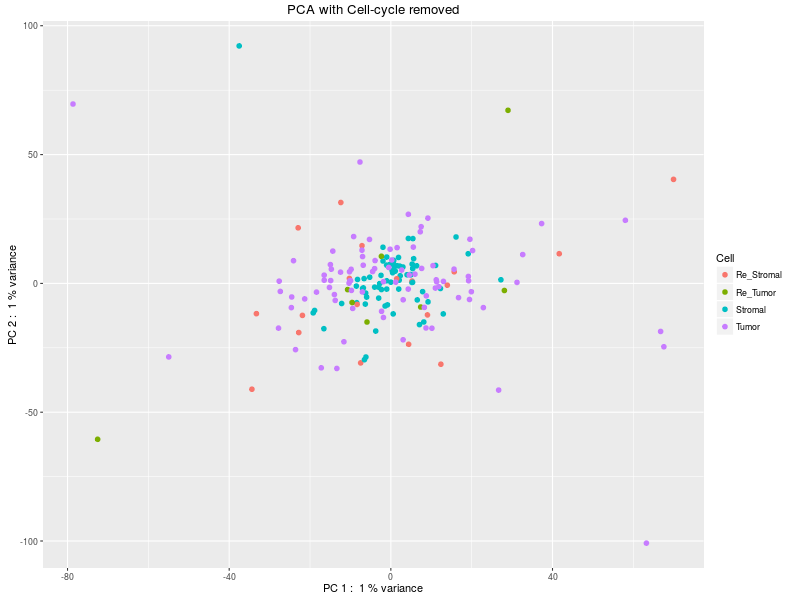

In [252]:
%%R -w 800 -h 600
FinalPCAData <- t(CellCycleRemoved[order(rowVars(CellCycleRemoved), decreasing=TRUE)[1:10000],])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Cell-cycle removed")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

In [195]:
%%R
#set.seed(1)
tsne_out <- Rtsne(t(exprs(cdScesetFilteredReasGeneID)),check_duplicates = FALSE, pca = TRUE, 
              perplexity=30, theta=0.5, dims=2)

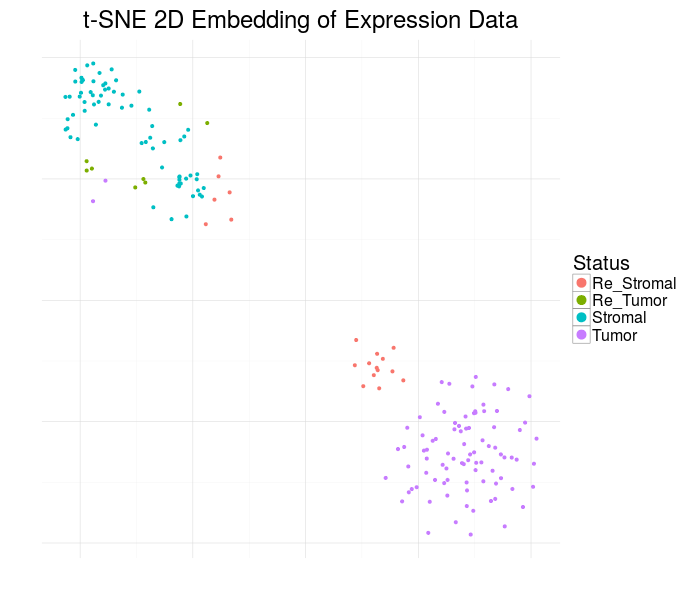

In [196]:
%%R -w 700 -h 600
p <- ggplot(as.data.frame(tsne_out$Y), aes(x=V1, y=V2, color=Status)) +
     geom_point(size=1.25) +
     guides(colour = guide_legend(override.aes = list(size=4))) +
     xlab("") + ylab("") +
     ggtitle("t-SNE 2D Embedding of Expression Data") +
     theme_light(base_size=20) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p)

In [95]:
%%R
cdCellCycleCorrected <- CellCycleRemoved
FilteredDataInfoReas <- data.frame(Cell=colnames(cdCellCycleCorrected), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdCellCycleCorrected)))
rownames(FilteredDataInfoReas) <- colnames(cdCellCycleCorrected)
pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetCellCycleCorrected <- newSCESet(countData = cdCellCycleCorrected, phenoData = pd)

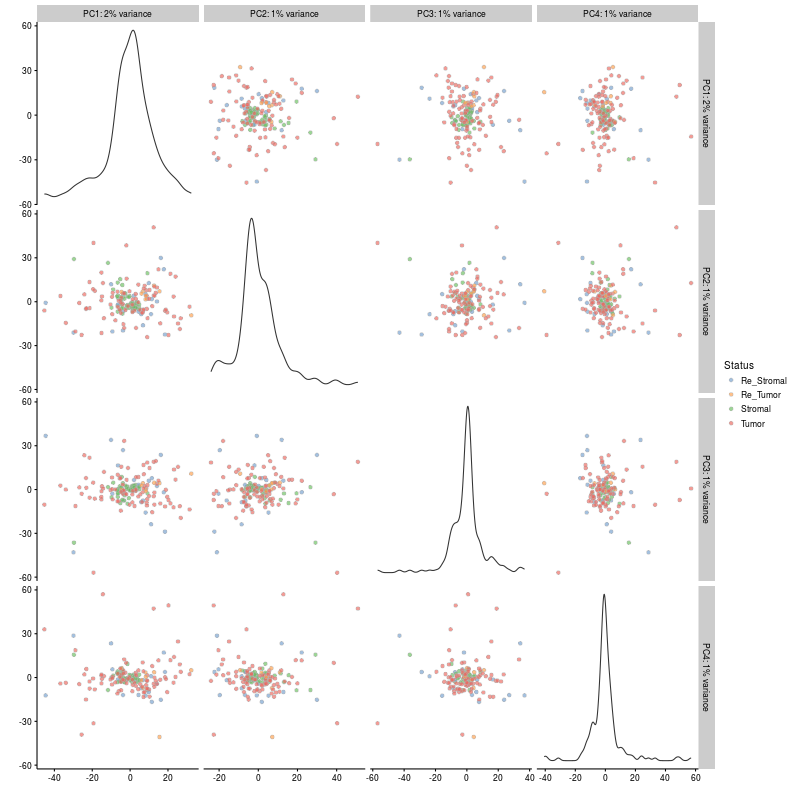

In [101]:
%%R -w 800 -h 800
plotPCA(cdScesetCellCycleCorrected, ncomponents = 4, colour_by = "Status", ntop=10000, exprs="counts")

## Cell-cycle Gene from Evan Z. Macosko

In [8]:
%%R
hgCellCycle <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/Cell-Cycle-Gene_Evan_Macosko.txt', header=TRUE)
x <- t(scale(t(exprs(cdScesetFilteredReasGeneID)), scale=FALSE, center=TRUE))
allGenes <- data.frame(geneName=rownames(x), Status=FALSE)
allGenes[as.character(allGenes$geneName) %in% hgCellCycle$Ensembl.Gene.ID,2] = TRUE
if.cc <- allGenes[,2]
dat <-list(x =x ,if.cc = if.cc)


Error in exprs(cdScesetFilteredReasGeneID) : 
  object 'cdScesetFilteredReasGeneID' not found


/usr/local/lib/python2.7/dist-packages/rpy2/robjects/functions.py:106: UserWarning: Error in exprs(cdScesetFilteredReasGeneID) : 
  object 'cdScesetFilteredReasGeneID' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [206]:
%%R
length(if.cc[if.cc == TRUE])

[1] 526


In [200]:
%%R
CellCycleRemoved <- ccRemover.main(dat,cutoff=3, max.it=4, nboot=200, ntop=10)


Iteration  1 ...
Bootstrapping 1 ...
Bootstrapping 2 ...
Bootstrapping 3 ...
Bootstrapping 4 ...
Bootstrapping 5 ...
Bootstrapping 6 ...
Bootstrapping 7 ...
Bootstrapping 8 ...
Bootstrapping 9 ...
Bootstrapping 10 ...
Bootstrapping 11 ...
Bootstrapping 12 ...
Bootstrapping 13 ...
Bootstrapping 14 ...
Bootstrapping 15 ...
Bootstrapping 16 ...
Bootstrapping 17 ...
Bootstrapping 18 ...
Bootstrapping 19 ...
Bootstrapping 20 ...
Bootstrapping 21 ...
Bootstrapping 22 ...
Bootstrapping 23 ...
Bootstrapping 24 ...
Bootstrapping 25 ...
Bootstrapping 26 ...
Bootstrapping 27 ...
Bootstrapping 28 ...
Bootstrapping 29 ...
Bootstrapping 30 ...
Bootstrapping 31 ...
Bootstrapping 32 ...
Bootstrapping 33 ...
Bootstrapping 34 ...
Bootstrapping 35 ...
Bootstrapping 36 ...
Bootstrapping 37 ...
Bootstrapping 38 ...
Bootstrapping 39 ...
Bootstrapping 40 ...
Bootstrapping 41 ...
Bootstrapping 42 ...
Bootstrapping 43 ...
Bootstrapping 44 ...
Bootstrapping 45 ...
Bootstrapping 46 ...
Bootstrapping 47 ...
Boot

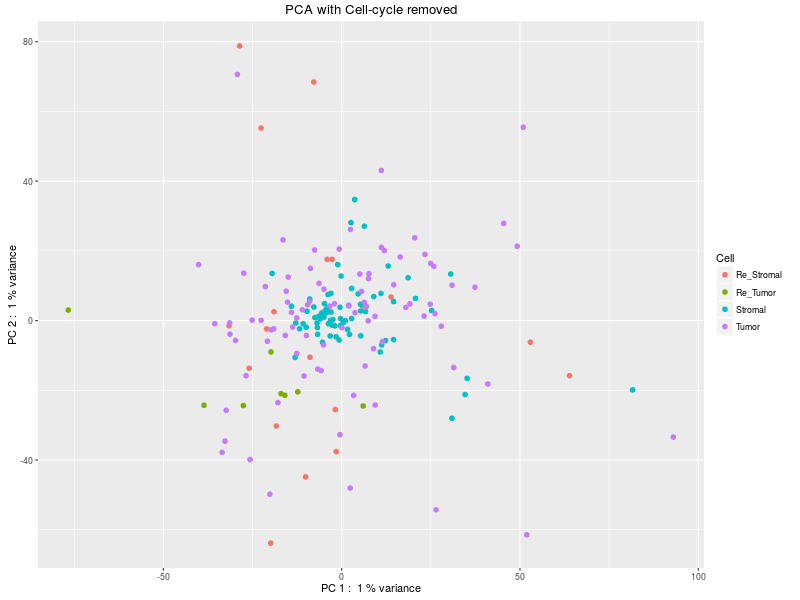

In [201]:
%%R -w 800 -h 600
FinalPCAData <- t(CellCycleRemoved[order(rowVars(CellCycleRemoved), decreasing=TRUE)[1:10000],])
sampleCondition <- FilteredDataInfoReas$Status
#strain <- factor(sampleCondition, levels=c("Stromal", "Tumour"),labels=c("Stromal", "Tumour"))
Status <- as.factor(sampleCondition)
PCx=1
PCy=2
pcaPRComp <- prcomp(FinalPCAData)
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy],Cell=Status)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with Cell-cycle removed")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
#p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdScesetFilteredReas))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
print(p1)

## Infering Copy Number Variation (CNV)
I used inferCNV to infer the copy number variation. Main objective is to see whether we can detect Aneuploidy. The script was changed to support R-3.2.1

In [ ]:
./R/inferCNV.R   --cutoff 4.5   --noise_filter 0.3   --pdf Louisa_Tumor_vs_Stromal_Stromal_NoContamination.pdf   --vis_bound_threshold " -1,1" --ref Louisa_data/Louisa_Stromal_AllContDeleted.txt 
Louisa_data/log2_cpmAllCells_ReAssigned.csv Louisa_data/gencodev24_mod_gen_pos.csv

### Further filtering the genes to came to same gene numbers as shown by Patel et. al.

In [240]:
%%R
cdForFurthFilter <- read.csv('/home/baker/inferCNV/Louisa_data/log2_cpmAllCells_ReAssigned.csv', sep='\t', header=T, row.names=1)
cdForFurthFilter <- cdForFurthFilter[rowMeans(cdForFurthFilter) > 1.75,]
dim(cdForFurthFilter)
#write.table(cdForFurthFilter,'/home/baker/inferCNV/Louisa_data/log2_cpm_FurtherFiltered_TabSep.csv', sep='\t', quote=FALSE)

[1] 6049  185


## Correlation Analysis

In [209]:
%%R
cor.val <- cor(exprs(cdScesetFilteredReasGeneID))

In [211]:
%%R
symnum(cor.val)

               St_C1 St_C2 St_C3 St_C4 St_C5 St_C6 St_C7 St_C8 St_C9 S_C10
Stromal_C1     1                                                          
Stromal_C2           1                                                    
Stromal_C3                 1                                              
Stromal_C4                       1                                        
Stromal_C5           .                 1                                  
Stromal_C6                                   1                            
Stromal_C7                                         1                      
Stromal_C8                                               1                
Stromal_C9           .                 .                       1          
Stromal_C10                                                          1    
Stromal_C11                                                               
Stromal_C12                                                               
Stromal_C13              

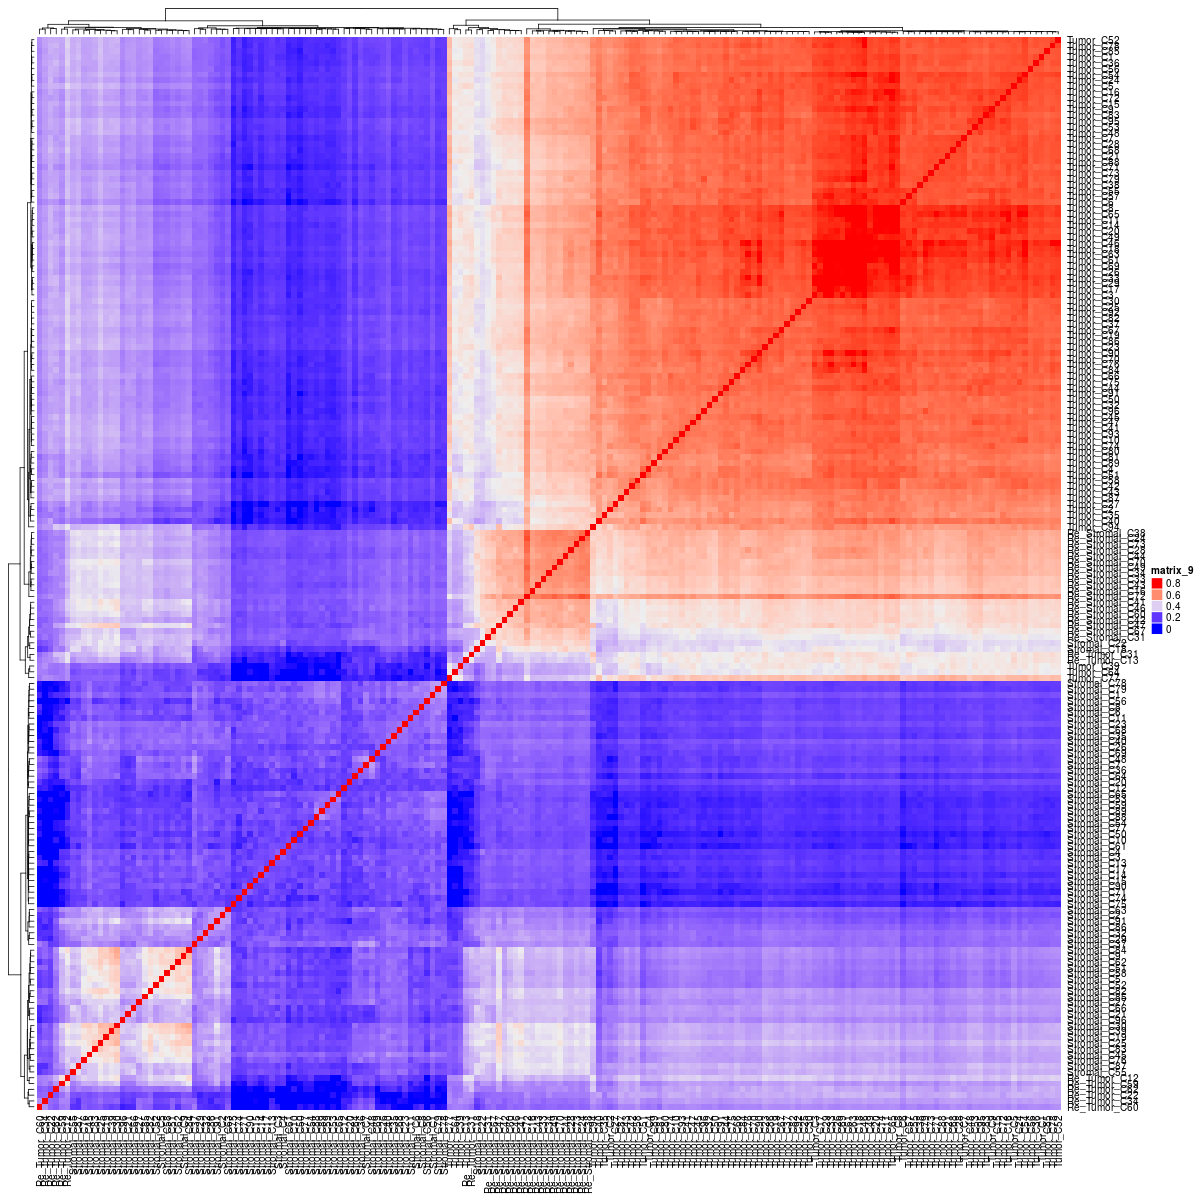

In [220]:
%%R -w 1200 -h 1200
cor.val <- cor(exprs(cdScesetFilteredReasGeneID), method='pearson')
Heatmap(cor.val, row_names_gp = gpar(fontsize = 10), column_names_gp = gpar(fontsize = 10))

In [224]:
%%R
save.image("Louisa_Workspace_withCorrelation.RData")

## DE analysis of Intra-clusters

First we will take out the cells that are grouped into different clusters. Then we will do a DE analysis between those clusters to find out the genes that are significantly differentially expressed between different groups. I am looking to use multiple tools for that, namely

- SCDE
- D3E
- MAST
- BPSC

In [7]:
%%R
load("/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/Heterogeneity_AnalysisReAssigned.RData")

In [8]:
%%R
ClustTree <- cutree(hc,6)
Cluster1 <- names(ClustTree[ClustTree == 1])
Cluster2 <- names(ClustTree[ClustTree == 2])
Cluster3 <- names(ClustTree[ClustTree == 3])
Cluster4 <- names(ClustTree[ClustTree == 4])
Cluster5 <- names(ClustTree[ClustTree == 5])
Cluster6 <- names(ClustTree[ClustTree == 6])

In [11]:
%%R
cdFilteredReas <- read.csv('/home/baker/Rna-seq_Data-Analysis/Louisa_Nelson_Single_Cell_Analysis/cdFilteredReasGeneAnnot.csv', row.names=1, header=TRUE)
FilteredDataInfoReas <- data.frame(Cell=colnames(cdFilteredReas), Status=gsub('([A-z]+)_.*', '\\1', colnames(cdFilteredReas)))
rownames(FilteredDataInfoReas) <- colnames(cdFilteredReas)

pd <- new("AnnotatedDataFrame", data = FilteredDataInfoReas)
rownames(pd) <- pd$Cell
cdScesetFiltered <- newSCESet(countData = cdFilteredReas, phenoData = pd)

In [12]:
%%R
Clsuter1Read <- counts(cdScesetFiltered)[,Cluster1]
colnames(Clsuter1Read) <- paste0('Cl1_',colnames(Clsuter1Read))
Clsuter2Read <- counts(cdScesetFiltered)[,Cluster2]
colnames(Clsuter2Read) <- paste0('Cl2_',colnames(Clsuter2Read))
Clsuter3Read <- counts(cdScesetFiltered)[,Cluster3]
colnames(Clsuter3Read) <- paste0('Cl3_',colnames(Clsuter3Read))
Clsuter4Read <- counts(cdScesetFiltered)[,Cluster4]
colnames(Clsuter4Read) <- paste0('Cl4_',colnames(Clsuter4Read))
Clsuter5Read <- counts(cdScesetFiltered)[,Cluster5]
colnames(Clsuter5Read) <- paste0('Cl5_',colnames(Clsuter5Read))
Clsuter6Read <- counts(cdScesetFiltered)[,Cluster6]
colnames(Clsuter6Read) <- paste0('Cl6_',colnames(Clsuter6Read))

In [18]:
%%R
write.csv(colnames(Clsuter6Read), 'Cluster6.txt', row.names=F)

## Starting SCDE with for cluster 5 and 6 (Tumor dominating clusters)

In [75]:
%%R
cnts <- cbind(Clsuter5Read,Clsuter6Read)
groups <- factor(gsub("(Cl5|Cl6).*", "\\1", colnames(cnts)), levels = c("Cl5", "Cl6"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl5 Cl6 
 53  41 


In [76]:
%%R
o.ifm <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

In [77]:
%%R
priors <- scde.expression.prior(
    models = o.ifm,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

In [78]:
%%R
resSCDE <- scde.expression.difference(
    o.ifm,
    cnts,
    priors,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

In [79]:
%%R
# Convert Z-scores into 2-tailed p-values
pValsSCDE <- pnorm(abs(resSCDE$cZ), lower.tail = FALSE) * 2 
pValsSCDE <- p.adjust(pValsSCDE, method = "bonferroni")

In [86]:
%%R
resSCDE_Cl5_vs_Cl6 <- resSCDE
resSCDE_Cl5_vs_Cl6 <- cbind(resSCDE_Cl5_vs_Cl6, pValsSCDE)
resSCDE_Cl5_vs_Cl6 <- resSCDE_Cl5_vs_Cl6[order(pValsSCDE, decreasing=FALSE),]
head(resSCDE_Cl5_vs_Cl6)
write.csv(resSCDE_Cl5_vs_Cl6, 'Result_Cl5_vs_Cl6.csv')

### Comparing cluster 4 vs 5

In [93]:
%%R
cnts <- cbind(Clsuter4Read,Clsuter5Read)
groups <- factor(gsub("(Cl4|Cl5).*", "\\1", colnames(cnts)), levels = c("Cl4", "Cl5"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl4 Cl5 
 20  53 


In [94]:
%%R
o.ifm.cl5_vs_cl6 <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

priors.cl5_vs_cl6 <- scde.expression.prior(
    models = o.ifm.cl5_vs_cl6,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

resSCDE.cl5_vs_cl6 <- scde.expression.difference(
    o.ifm.cl5_vs_cl6,
    cnts,
    priors.cl5_vs_cl6,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

# Convert Z-scores into 2-tailed p-values
pValsSCDE.cl5_vs_cl6 <- pnorm(abs(resSCDE.cl5_vs_cl6$cZ), lower.tail = FALSE) * 2 
pValsSCDE.cl5_vs_cl6 <- p.adjust(pValsSCDE.cl5_vs_cl6, method = "bonferroni")


resSCDE.cl5_vs_cl6 <- resSCDE.cl5_vs_cl6
resSCDE.cl5_vs_cl6 <- cbind(resSCDE.cl5_vs_cl6, pValsSCDE.cl5_vs_cl6)
resSCDE.cl5_vs_cl6 <- resSCDE.cl5_vs_cl6[order(pValsSCDE.cl5_vs_cl6, decreasing=FALSE),]
head(resSCDE.cl5_vs_cl6)
write.csv(resSCDE.cl5_vs_cl6, 'Result.cl5_vs_cl6.csv')

### Comparing Cluster 4 vs 6

In [10]:
%%R
cnts <- cbind(Clsuter4Read,Clsuter6Read)
groups <- factor(gsub("(Cl4|Cl6).*", "\\1", colnames(cnts)), levels = c("Cl4", "Cl6"))
# the group factor should be named accordingly
names(groups) <- colnames(cnts)
table(groups)

groups
Cl4 Cl6 
 20  41 


In [11]:
%%R
o.ifm.cl4_vs_cl6 <- scde.error.models(
    counts = cnts,
    groups = groups,
    n.cores = 1,
    threshold.segmentation = TRUE,
    save.crossfit.plots = FALSE,
    save.model.plots = FALSE,
    verbose = 0,
    min.size.entries = 2
)

priors.cl4_vs_cl6 <- scde.expression.prior(
    models = o.ifm.cl4_vs_cl6,
    counts = cnts,
    length.out = 400,
    show.plot = FALSE
)

resSCDE.cl4_vs_cl6 <- scde.expression.difference(
    o.ifm.cl4_vs_cl6,
    cnts,
    priors.cl4_vs_cl6,
    groups = groups,
    n.randomizations = 100,
    n.cores = 1,
    verbose = 0
)

# Convert Z-scores into 2-tailed p-values
pValsSCDE.cl4_vs_cl6 <- pnorm(abs(resSCDE.cl4_vs_cl6$cZ), lower.tail = FALSE) * 2 
pValsSCDE.cl4_vs_cl6 <- p.adjust(pValsSCDE.cl4_vs_cl6, method = "bonferroni")


resSCDE.cl4_vs_cl6 <- resSCDE.cl4_vs_cl6
resSCDE.cl4_vs_cl6 <- cbind(resSCDE.cl4_vs_cl6, pValsSCDE.cl4_vs_cl6)
resSCDE.cl4_vs_cl6 <- resSCDE.cl4_vs_cl6[order(pValsSCDE.cl4_vs_cl6, decreasing=FALSE),]
head(resSCDE.cl4_vs_cl6)
write.csv(resSCDE.cl4_vs_cl6, 'Result.cl4_vs_cl6.csv')